# RM3100 vs USGS Observatory

In this notebook, I will compare data collected from an RM3100 magnetometer located in my garage in Anchorage with data from a real (USGS) geomagnetic observatory located in Sitka.


I am using a rolling mean to smooth out my data as it was very noisy.

### F : The total Field, or total magnitude of the earth's magnetic field in nT (nano tesla).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime


df = pd.read_csv('magtest_garagefloor2.txt', parse_dates=[0], header=None, skiprows=3)
df.columns = ['LocalTime', 'F', 'X', 'Y', 'Z']
df.loc[:,'F_mean'] = df['F'].rolling(window=200, center=True).mean()

#observatory SIT = Sitka,  BRW = Barrow,  CMO = Fairbanks
obs = 'SIT'
timeoffset = 9   #AKST time zone


The data at the observatory is on GMT time and Alaska is currently 9 hours behind. As such, I have to adjust the observatory timestamp to the local time stamp.

In [2]:
#Set the start and end for the data to get from the USGS observatory. 
starttime = datetime.datetime.strftime(df['LocalTime'].min() + 
                              datetime.timedelta(hours=9), 
                              '%Y-%m-%dT%H:%M:%S') 
endtime =  datetime.datetime.strftime(df['LocalTime'].max() + 
                              datetime.timedelta(hours=9),
                              '%Y-%m-%dT%H:%M:%S')

Here I am using the USGS API to get data via HTTP request, and read it directly into a pandas dataframe. I manually set the columns and skip the header info. Then I create a local time stamp and perform a soft merge (because time stamps in their data might not match mine to the second) in order to join the data to the nearest second.

I have included a string variable for the observatory so that I can easily go back and see how my data compares with Fairbanks or Barrow as well.

In [3]:
def get_obs_data(obs, starttime, endtime, timeoffset, df):
    
    csvstring = f"https://geomag.usgs.gov/ws/edge/?id={obs}&elements=" \
                f"H,D,Z,F&starttime={starttime}&endtime={endtime}"
    df_obs = pd.read_csv(csvstring, skiprows=21, delim_whitespace=True, 
                        parse_dates=[[0,1]], header=None)
    df_obs.columns = ['GMTTime', 
                    'DOY', 
                    f'{obs}H', 
                    f'{obs}D', 
                    f'{obs}Z', 
                    f'{obs}F']

    df_obs['LocalTime'] = df_obs['GMTTime'] - datetime.timedelta(hours=timeoffset)
    dfresult = pd.merge_asof(df, df_obs, on='LocalTime')

    #Calculate a rolling correlation to see how well my data matches up with USGS data.
    dfresult.loc[:,f'{obs}F'] = dfresult[f'{obs}F'].fillna(method='bfill')
    dfresult['Corr'] = dfresult['F_mean'].rolling(100).corr(dfresult[f'{obs}F'])
    return dfresult

In [4]:
dfresult = get_obs_data(obs, starttime, endtime, timeoffset, df)

In order to see both curves clearly on the same plot, I am applying a "gain" and an offset to my data.

In [5]:
#Set a gain an calculate offset to apply to *match* with USGS data
gain = 6
offset = dfresult[f'{obs}F'].mean() - gain*dfresult['F_mean'].mean()

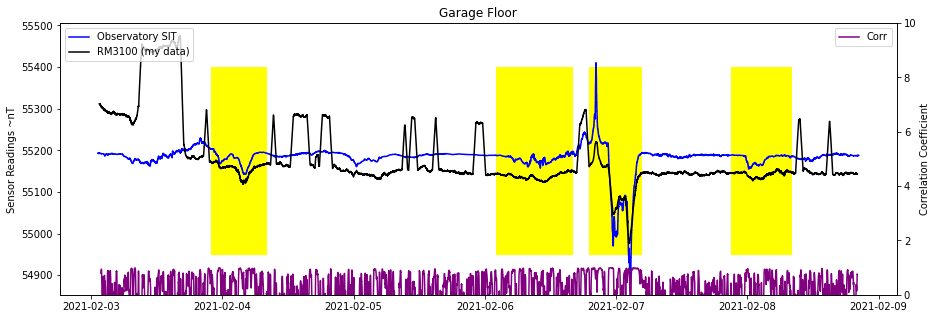

In [6]:
#Plot stuff
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
from datetime import datetime

def draw_date_patch(ax, startTime, endTime, y0, height):
    startTime = datetime.strptime(startTime, '%Y-%m-%d %H:%M')
    endTime = datetime.strptime(endTime, '%Y-%m-%d %H:%M')
    start = mdates.date2num(startTime)
    end = mdates.date2num(endTime)
    width = end - start
    rect = Rectangle((start, y0), width, height, color='yellow')
    ax.add_patch(rect)  
  
plt.rcParams['figure.figsize'] = [15, 5]

fig, ax = plt.subplots()
ax.plot(dfresult['LocalTime'], dfresult[f'{obs}F'], label=f'Observatory {obs}', color='blue')
ax.plot(dfresult['LocalTime'], dfresult['F_mean']*gain + offset, label='RM3100 (my data)', color='black')
plt.ylabel('Sensor Readings ~nT')
plt.legend(loc='upper left')

#highlight areas of interest
draw_date_patch(ax, '2021-02-03 22:00', '2021-02-04 08:00', 54950, 450)
draw_date_patch(ax, '2021-02-06 02:00', '2021-02-06 16:00', 54950, 450)
draw_date_patch(ax, '2021-02-06 19:00', '2021-02-07 04:30', 54950, 450)
draw_date_patch(ax, '2021-02-07 21:00', '2021-02-08 08:00', 54950, 450)

ax2 = ax.twinx()
ax2.plot(dfresult['LocalTime'], dfresult['Corr'], color='purple', label='Corr')
ax2.set_ylim(0,10)

plt.ylabel('Correlation Coefficient')
plt.xlabel('Time')
plt.title('Garage Floor')
plt.legend(loc='upper right')

#### Examples of good correlation

Let's take a closer look at a few areas of interest where the magnetic activity was greatest. (See yellow high lighted areas above)

* Example 1 - Start: 2021-02-03 22:00, End: 2021-02-04 08:00
* Example 2 - Start: 2021-02-06 02:00, End: 2021-02-06 16:00
* Example 3 - Start: 2021-02-06 19:00, End: 2021-02-07 04:30
* Example 4 - Start: 2021-02-07 21:00, End: 2021-02-08 08:00

In [7]:
dfex1 = dfresult[(dfresult['LocalTime'] > '2021-02-03 22:00') & (dfresult['LocalTime'] < '2021-02-04 08:00')]
dfex2 = dfresult[(dfresult['LocalTime'] > '2021-02-06 02:00') & (dfresult['LocalTime'] < '2021-02-06 16:00')]
dfex3 = dfresult[(dfresult['LocalTime'] > '2021-02-06 19:00') & (dfresult['LocalTime'] < '2021-02-07 04:30')]
dfex4 = dfresult[(dfresult['LocalTime'] > '2021-02-07 21:00') & (dfresult['LocalTime'] < '2021-02-08 08:00')]


In [8]:
#Example 1-4 correlations

print(round(dfex1['F_mean'].corr(dfex1[f'{obs}F']),3))
print(round(dfex2['F_mean'].corr(dfex2[f'{obs}F']),3))
print(round(dfex3['F_mean'].corr(dfex3[f'{obs}F']),3))
print(round(dfex4['F_mean'].corr(dfex4[f'{obs}F']),3))

0.904
0.838
0.967
0.875


### Correlations

I re-ran this notebook to compare the correlation with the different observatories to see which one has the best correlation. It seems that Sitka is the best overall, despite the fact that Fairbanks is geographically closest to where I live. 

My Data 

| Correlations| Sitka | Fairbanks | Barrow |
| ----------- | ------|-----------|--------|
| EX1         | 0.904 | 0.890     | -0.635 |
| EX2         | 0.838 | 0.890     |  0.024 |
| EX3         | 0.967 | 0.428     | -0.626 |
| EX4         | 0.875 | 0.833     |  0.284 |





## Plots, Ex 1-4

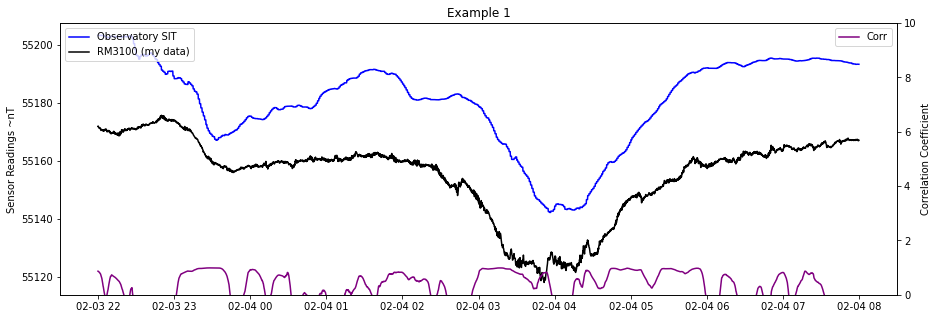

In [10]:
fig, ax = plt.subplots()
ax.plot(dfex1['LocalTime'], dfex1[f'{obs}F'], label=f'Observatory {obs}', color='blue')
ax.plot(dfex1['LocalTime'], dfex1['F_mean']*gain + offset, label='RM3100 (my data)', color='black')
plt.ylabel('Sensor Readings ~nT')
plt.legend(loc='upper left')

ax2 = ax.twinx()
ax2.plot(dfex1['LocalTime'], dfex1['Corr'], color='purple', label='Corr')
ax2.set_ylim(0,10)

plt.ylabel('Correlation Coefficient')
plt.xlabel('Time')
plt.title('Example 1')
plt.legend(loc='upper right')

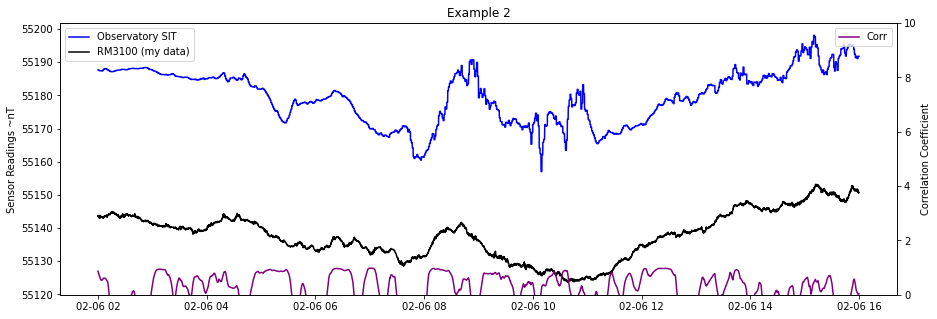

In [11]:
fig, ax = plt.subplots()
ax.plot(dfex2['LocalTime'], dfex2[f'{obs}F'], label=f'Observatory {obs}', color='blue')
ax.plot(dfex2['LocalTime'], dfex2['F_mean']*gain + offset, label='RM3100 (my data)', color='black')
plt.ylabel('Sensor Readings ~nT')
plt.legend(loc='upper left')

ax2 = ax.twinx()
ax2.plot(dfex2['LocalTime'], dfex2['Corr'], color='purple', label='Corr')
ax2.set_ylim(0,10)

plt.ylabel('Correlation Coefficient')
plt.xlabel('Time')
plt.title('Example 2')
plt.legend(loc='upper right')

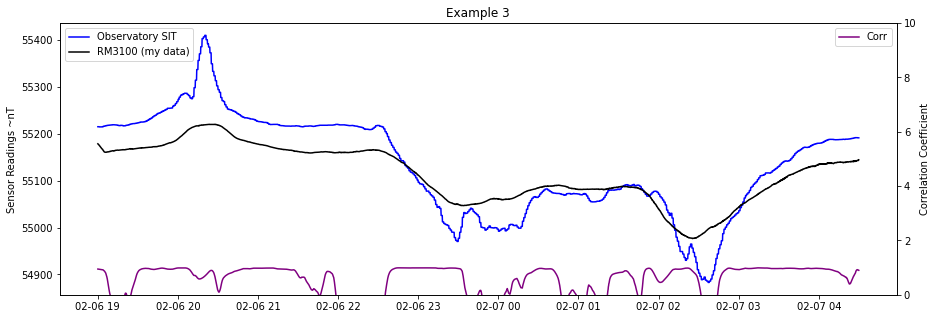

In [12]:
fig, ax = plt.subplots()
ax.plot(dfex3['LocalTime'], dfex3[f'{obs}F'], label=f'Observatory {obs}', color='blue')
ax.plot(dfex3['LocalTime'], dfex3['F_mean']*gain + offset, label='RM3100 (my data)', color='black')
plt.ylabel('Sensor Readings ~nT')
plt.legend(loc='upper left')

ax2 = ax.twinx()
ax2.plot(dfex3['LocalTime'], dfex3['Corr'], color='purple', label='Corr')
ax2.set_ylim(0,10)

plt.ylabel('Correlation Coefficient')
plt.xlabel('Time')
plt.title('Example 3')
plt.legend(loc='upper right')

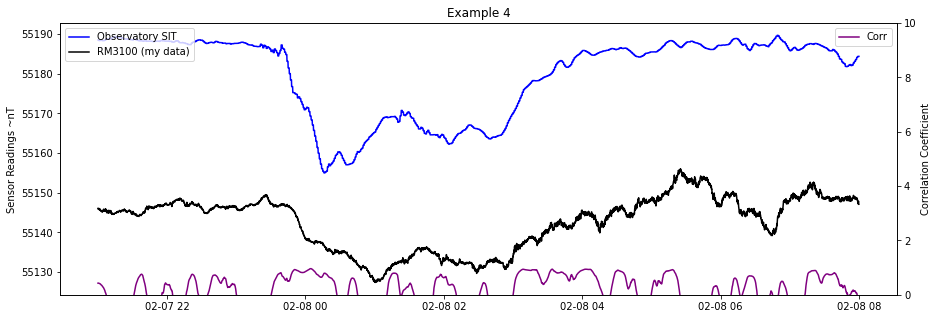

In [13]:
fig, ax = plt.subplots()
ax.plot(dfex4['LocalTime'], dfex4[f'{obs}F'], label=f'Observatory {obs}', color='blue')
ax.plot(dfex4['LocalTime'], dfex4['F_mean']*gain + offset, label='RM3100 (my data)', color='black')
plt.ylabel('Sensor Readings ~nT')
plt.legend(loc='upper left')

ax2 = ax.twinx()
ax2.plot(dfex4['LocalTime'], dfex4['Corr'], color='purple', label='Corr')
ax2.set_ylim(0,10)

plt.ylabel('Correlation Coefficient')
plt.xlabel('Time')
plt.title('Example 4')
plt.legend(loc='upper right')